In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm

# Set seeds
torch.manual_seed(42)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
train_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\train"
test_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\test"

# Image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20
PATIENCE = 5

# Data augmentation
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



In [3]:

# Datasets and Dataloaders
#train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
#test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [17]:
# Extract targets (class labels) for stratification
targets = np.array([label for _, label in train_dataset])
indices = np.arange(len(train_dataset))

# 80% train, 20% val (you can change this ratio)
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create training and validation subsets
train_subset = Subset(train_dir, train_idx)
val_subset = Subset(train_dir, val_idx)

# Set correct transforms for validation subset
# We need to manually override transforms because full_train_dataset used augmentation
val_subset.dataset.transform = test_transforms

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Create subset datasets
#train_subset = Subset(train_dataset, train_idx)
#val_subset = Subset(train_dataset, val_idx)

AttributeError: 'str' object has no attribute 'transform'

In [5]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)


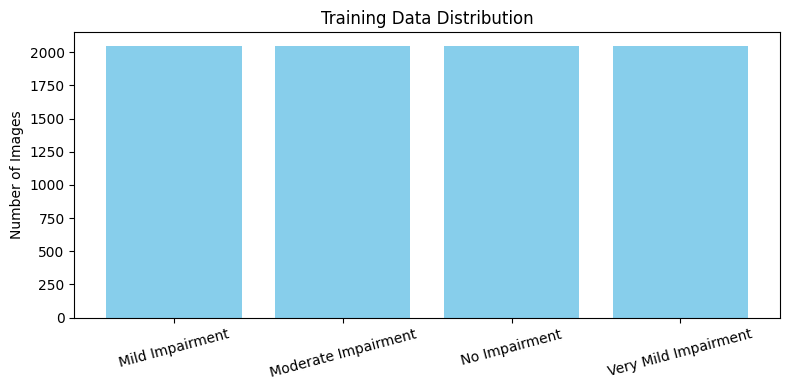

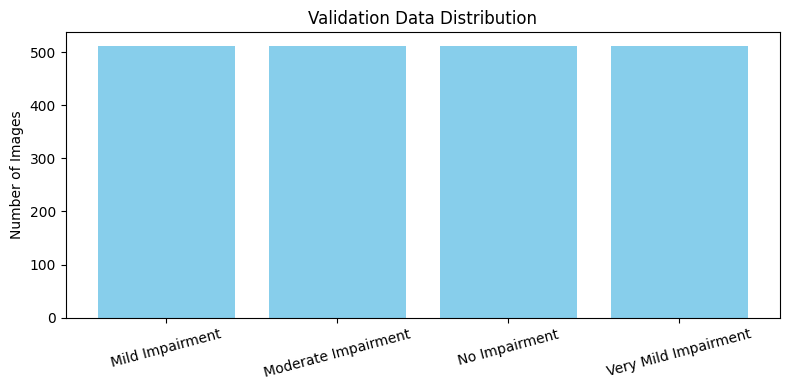

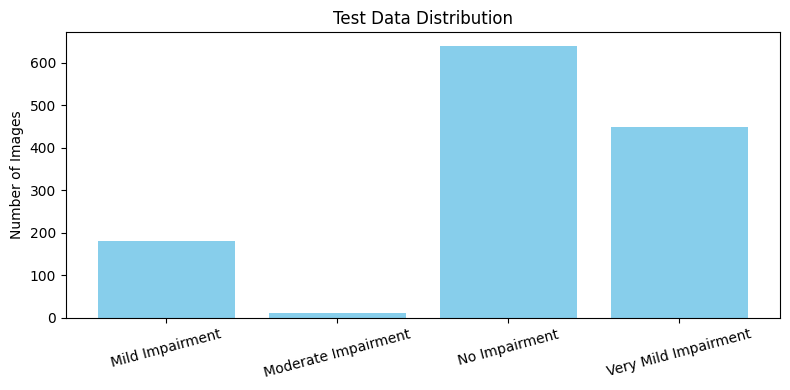

In [10]:
#from collections import Counter

# Training set
#train_counts = Counter([label for _, label in train_dataset])
#print("Train class counts:", train_counts)

# Map label indices to class names
#print("Class mapping:", train_dataset.class_to_idx)

#idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
#for class_idx, count in train_counts.items():
#    print(f"Class '{idx_to_class[class_idx]}': {count} images")

import matplotlib.pyplot as plt
from collections import Counter

# Get class index-to-name mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Count training labels
train_labels = [train_dataset[i][1] for i in train_idx]
train_counts = Counter(train_labels)

# Count validation labels
val_labels = [train_dataset[i][1] for i in val_idx]
val_counts = Counter(val_labels)

# Count test labels
test_labels = [label for _, label in test_dataset]
test_counts = Counter(test_labels)

# Function to plot class distribution
def plot_distribution(counts, title):
    labels = [idx_to_class[i] for i in range(NUM_CLASSES)]
    values = [counts[i] for i in range(NUM_CLASSES)]

    plt.figure(figsize=(8, 4))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Plot all three
plot_distribution(train_counts, "Training Data Distribution")
plot_distribution(val_counts, "Validation Data Distribution")
plot_distribution(test_counts, "Test Data Distribution")


In [15]:
#from sklearn.metrics import classification_report

# After evaluation
#print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


In [7]:
# Model definition
class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 516, 3, padding=1), nn.ReLU(),
            nn.Conv2d(516, 516, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(516),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(516 * 7 * 7, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.7),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = AlzheimerCNN(NUM_CLASSES).to(device)



In [27]:
from torchsummary import summary

# Replace with your actual model and input size
summary(model, input_size=(3, 224, 224))  # for image models, for example


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
            Conv2d-3         [-1, 16, 224, 224]           2,320
              ReLU-4         [-1, 16, 224, 224]               0
       BatchNorm2d-5         [-1, 16, 224, 224]              32
         MaxPool2d-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           4,640
              ReLU-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,248
             ReLU-10         [-1, 32, 112, 112]               0
      BatchNorm2d-11         [-1, 32, 112, 112]              64
        MaxPool2d-12           [-1, 32, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          18,496
             ReLU-14           [-1, 64,

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping variables
best_loss = np.inf
counter = 0


In [15]:
import matplotlib.pyplot as plt
import torch

# Initialize lists to store accuracies for plotting
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        
        running_loss += loss.item()

    # Average training loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train.double() / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels.data)
            total_val += labels.size(0)

            val_loss += loss.item()

    # Average validation loss and accuracy for this epoch
    val_loss /= len(val_loader)
    val_accuracy = correct_val.double() / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 256/256 [01:08<00:00,  3.74it/s]


Epoch [1/20] - Train Loss: 1.0312, Train Acc: 0.5295, Val Loss: 1.5318, Val Acc: 0.2959


Epoch 2/20: 100%|██████████| 256/256 [01:15<00:00,  3.38it/s]


Epoch [2/20] - Train Loss: 0.9330, Train Acc: 0.5813, Val Loss: 1.6609, Val Acc: 0.2729


Epoch 3/20: 100%|██████████| 256/256 [01:23<00:00,  3.07it/s]


Epoch [3/20] - Train Loss: 0.9580, Train Acc: 0.5604, Val Loss: 1.0204, Val Acc: 0.5361


Epoch 4/20: 100%|██████████| 256/256 [01:25<00:00,  2.99it/s]


Epoch [4/20] - Train Loss: 0.9379, Train Acc: 0.5714, Val Loss: 2.0821, Val Acc: 0.3730


Epoch 5/20: 100%|██████████| 256/256 [01:26<00:00,  2.96it/s]


Epoch [5/20] - Train Loss: 0.8933, Train Acc: 0.5914, Val Loss: 1.8300, Val Acc: 0.3037


Epoch 6/20: 100%|██████████| 256/256 [01:26<00:00,  2.96it/s]


Epoch [6/20] - Train Loss: 0.8880, Train Acc: 0.5947, Val Loss: 1.0770, Val Acc: 0.5112


Epoch 7/20: 100%|██████████| 256/256 [01:25<00:00,  3.00it/s]


Epoch [7/20] - Train Loss: 0.8610, Train Acc: 0.5953, Val Loss: 0.7789, Val Acc: 0.6445


Epoch 8/20: 100%|██████████| 256/256 [01:25<00:00,  3.01it/s]


Epoch [8/20] - Train Loss: 0.7931, Train Acc: 0.6294, Val Loss: 0.9325, Val Acc: 0.5684


Epoch 9/20: 100%|██████████| 256/256 [01:26<00:00,  2.97it/s]


Epoch [9/20] - Train Loss: 0.7786, Train Acc: 0.6433, Val Loss: 1.0940, Val Acc: 0.5498


Epoch 10/20: 100%|██████████| 256/256 [01:25<00:00,  2.99it/s]


Epoch [10/20] - Train Loss: 0.7597, Train Acc: 0.6547, Val Loss: 1.2441, Val Acc: 0.5029


Epoch 11/20: 100%|██████████| 256/256 [01:24<00:00,  3.02it/s]


Epoch [11/20] - Train Loss: 0.7566, Train Acc: 0.6541, Val Loss: 9.9315, Val Acc: 0.2603


Epoch 12/20: 100%|██████████| 256/256 [01:30<00:00,  2.83it/s]


Epoch [12/20] - Train Loss: 0.8840, Train Acc: 0.6023, Val Loss: 0.8675, Val Acc: 0.5952


Epoch 13/20: 100%|██████████| 256/256 [01:31<00:00,  2.80it/s]


Epoch [13/20] - Train Loss: 0.7926, Train Acc: 0.6394, Val Loss: 0.7772, Val Acc: 0.6299


Epoch 14/20: 100%|██████████| 256/256 [01:25<00:00,  2.99it/s]


Epoch [14/20] - Train Loss: 0.7621, Train Acc: 0.6583, Val Loss: 0.7771, Val Acc: 0.6470


Epoch 15/20: 100%|██████████| 256/256 [01:24<00:00,  3.04it/s]


Epoch [15/20] - Train Loss: 0.7326, Train Acc: 0.6680, Val Loss: 0.7656, Val Acc: 0.6445


Epoch 16/20: 100%|██████████| 256/256 [01:24<00:00,  3.02it/s]


Epoch [16/20] - Train Loss: 0.7175, Train Acc: 0.6792, Val Loss: 1.4241, Val Acc: 0.5044


Epoch 17/20: 100%|██████████| 256/256 [04:15<00:00,  1.00it/s]  


Epoch [17/20] - Train Loss: 0.7152, Train Acc: 0.6753, Val Loss: 1.4445, Val Acc: 0.4819


Epoch 18/20: 100%|██████████| 256/256 [01:09<00:00,  3.67it/s]


Epoch [18/20] - Train Loss: 0.6977, Train Acc: 0.6909, Val Loss: 34.5454, Val Acc: 0.2500


Epoch 19/20: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s]


Epoch [19/20] - Train Loss: 0.6732, Train Acc: 0.7031, Val Loss: 16.1962, Val Acc: 0.2534


Epoch 20/20: 100%|██████████| 256/256 [01:20<00:00,  3.17it/s]


Epoch [20/20] - Train Loss: 0.6436, Train Acc: 0.7100, Val Loss: 1.6752, Val Acc: 0.4355


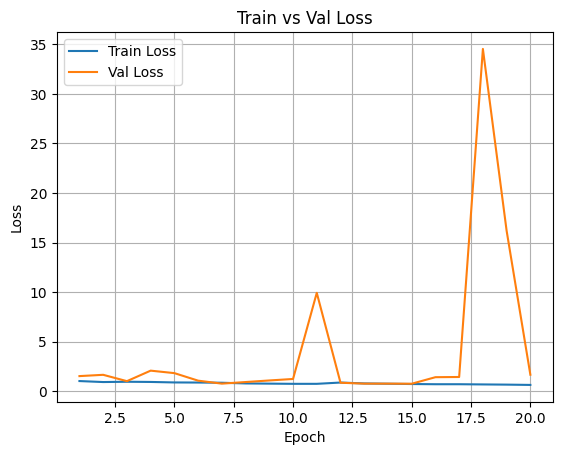

In [30]:
epochs = list(range(1,21 ))  # 20 epochs

train_loss = [1.03, 0.93, 0.96, 0.94, 0.89, 0.88, 0.86, 0.79, 0.77, 0.75,
              0.75, 0.88, 0.79, 0.76, 0.73, 0.71, 0.71, 0.69, 0.67, 0.64]

val_loss =   [1.53, 1.66, 1.02, 2.08, 1.83, 1.07, 0.77, 0.93, 1.09, 1.24,
              9.93, 0.86, 0.77, 0.77, 0.76, 1.42, 1.44, 34.54, 16.19, 1.67]

# Now plot
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)
plt.show()




In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

# Create empty lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names from dataset
class_names = list(val_dataset.class_to_idx.keys())

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'val_dataset' is not defined